In [1]:
import pandas as pd
import numpy as np
import ExMAS
import ExMAS.main
import ExMAS.utils
import pprint
import itertools
import csv
import os
import osmnx as ox
import dotmap
import sys
import random
import datetime
import requests
import time
import math
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16, 16]
import networkx as nx #graphs
cwd = os.getcwd()

import seaborn as sns
import matplotlib.pyplot as plt

local imports

In [2]:
from ExMAS.utils import inData as inData
from dotmap import DotMap
from main import make_query, parse_OTP_response
from utils import plot
from utils import get_config
from datetime import timedelta
from scipy import optimize

# 1 mode: Walk + PT

## 1.1 OTP (OD) for ALL PT users

In [3]:
PATH = 'georequests_O(area10)_D.csv'
OTP_API = "http://localhost:8080/otp/routers/default/plan"

params = get_config('default_SUM.json')

In [4]:
df = pd.read_csv(PATH)
df1 = df.filter(['origin_x','origin_y','destination_x', 'destination_y', 'treq'], axis = 1)
df1['treq'] = pd.to_datetime(df1.treq)

In [5]:
df_PT_OD = df1.apply(lambda row: 
                 parse_OTP_response(requests.get(OTP_API, params=make_query(row.squeeze())).json()), axis=1) #query OTP for each request

In [6]:
for name in list(df_PT_OD[0].keys()):
    vals = []
    for i in range(len(df_PT_OD)):
        if df_PT_OD[i]['success'] == True:
            vals.append(df_PT_OD[i][name])
        else:
            vals.append(None)
    df1[name] = vals

In [7]:
def PT_utility(requests, params):
    if 'walkDistance' in requests.columns:
        
        # params.ticket_price = 0.7
        
        requests = requests
        requests['PT_fare'] = 1 + requests.transitTime * params.avg_speed/1000 * params.ticket_price
        requests['u_PT'] = requests['PT_fare'] + \
                           params.VoT * (params.walk_factor * requests.walkDistance / params.speeds.walk +
                                           params.wait_factor * requests.waitingTime +
                                           params.transfer_penalty * requests.transfers + requests.transitTime)
    return requests

In [8]:
reqs_PT_OD = PT_utility(df1, params)
reqs_PT_OD. head(1)
# reqs.to_csv("PT_utility_OD(area10).csv")

,origin_x,origin_y,destination_x,destination_y,treq,success,n_itineraries,duration,walkDistance,transfers,transitTime,waitingTime,modes,PT_fare,u_PT
0,19.879109,50.017161,19.896833,50.02339,2024-03-28 07:45:04,True,3.0,1009.0,767.136977,1.0,300.0,87.0,"[[WALK, 231, 283], [BUS, 180, 582], [WALK, 35,...",1.315,9.198966


# 2 mode: RP + PT¶

## 2.1 ExMAS (OH) for ALL PT users

In [9]:
df = df1.filter(['origin_x','origin_y','destination_x', 'destination_y', 'treq'], axis = 1)
params = ExMAS.utils.get_config('default_SUM.json') # load the default
params.city = 'Krakow, Poland'
params = ExMAS.utils.make_paths(params) # update file paths
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
df

,origin_x,origin_y,destination_x,destination_y,treq
0,19.879109,50.017161,19.896833,50.023390,2024-03-28 07:45:04
1,19.862843,50.017554,19.883808,50.003198,2024-03-28 08:09:23
2,19.875724,50.010467,19.924829,50.049414,2024-03-28 07:50:47
3,19.871116,50.012975,19.952185,50.025729,2024-03-28 07:59:04
4,19.884374,50.017210,19.896833,50.023390,2024-03-28 07:55:23
...,...,...,...,...,...
161,19.884644,50.018121,19.968180,50.045767,2024-03-28 08:03:17
162,19.875970,50.011344,19.929784,50.063029,2024-03-28 08:12:23
163,19.873957,50.014724,19.956659,50.054149,2024-03-28 07:45:37
164,19.882427,50.018439,19.947150,50.069255,2024-03-28 08:03:19


In [10]:
def run_ExMAS_SUM(inData, params, hub, frac, repl):

    params.nP = int(frac * len(df))
    sample = df.sample(n = int(frac * len(df)), replace=False, weights=None, random_state=None, axis=None) # demand of RP=frac*population
    sample['origin'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['origin_y'], row['origin_x'])), axis = 1)
    # sample['destination'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['desti_y'], row['desti_x'])), axis = 1) # in case of O-D by PT
    if type(sample['treq'][0]) == str:
        sample['treq'] = sample['treq'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    # inData = ExMAS.utils.generate_demand(inData, params) #generate trip requests 
    inData.requests = sample
    
    
    my_requests = inData.requests
    my_requests['destination'] = hub[1] 
    my_requests["origin"] = sample.origin.values
    my_requests['dist'] = my_requests.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
    my_requests['ttrav'] = my_requests.apply(lambda request: pd.Timedelta(request.dist, 's').floor('s'), axis=1) 
    my_requests.tarr = [request.treq + request.ttrav for _, request in my_requests.iterrows()]
    my_requests['pax_id'] = list(range(len(my_requests)))
    
       
    inData.requests = my_requests
    # inData.requests.to_csv(f'res/10/ttrav_{hub[0]}_{frac}_{repl}.csv')
    inData = ExMAS.main(inData, params)
    schedule = inData.ExMAS.schedule
    requests = inData.ExMAS.requests
   
    KPIs = inData.sblts.res.to_frame()[:23]
    # KPIs['description']  = ExMAS.utils.KPIs_descriptions
    KPIs.columns = ['KPI']
    KPIs
    # KPIs.to_csv(f'res/10/KPI_{hub[0]}_{frac}_{repl}.csv') #res/     
   
    return KPIs, schedule, requests

params.shared_discount = 0.2
params.simTime = 0.5
params.t0 = params.t0.replace(hour=8)
params.speeds.ride = 6
params.VoT = 0.0035
params.pax_delay = 15
params.max_degree = 8 
params.price = 1.5
results = dict()
 
#    hubs   
hubs = [('hub1', ox.get_nearest_node(inData.G,[50.01844,19.88948]))]#

for frac in  [1]: #list of frac 0.001, 0.0015, 0.002, 0.003, 0.005, 0.007, 0.008, 0.009, 0.01
    for h in hubs:
        for i in range(1): 
            print(h[0], frac, i + 1)
            results[frac] = run_ExMAS_SUM(inData, params, h, frac, i)

hub1 1 1
13-05-24 14:52:13-INFO-Initializing pairwise trip shareability between 166 and 166 trips.
13-05-24 14:52:13-INFO-creating combinations
13-05-24 14:52:13-INFO-27390	 nR*(nR-1)
13-05-24 14:52:13-INFO-Reduction of feasible pairs by 99.35%
13-05-24 14:52:13-INFO-Degree 2 	Completed
13-05-24 14:52:13-INFO-trips to extend at degree 2 : 387
13-05-24 14:52:13-INFO-At degree 2 feasible extensions found out of 69 searched
13-05-24 14:52:13-INFO-Degree 3 	Completed
13-05-24 14:52:13-INFO-trips to extend at degree 3 : 69
13-05-24 14:52:13-INFO-At degree 3 feasible extensions found out of 12 searched
13-05-24 14:52:13-INFO-Degree 4 	Completed
13-05-24 14:52:13-INFO-trips to extend at degree 4 : 12
13-05-24 14:52:13-INFO-At degree 4 feasible extensions found out of 0 searched
13-05-24 14:52:13-INFO-Degree 5 	Completed
13-05-24 14:52:13-INFO-No more trips to exted at degree 5
13-05-24 14:52:14-INFO-Matching 166 trips to 634 rides in order to minimize u_veh
13-05-24 14:52:14-INFO-Problem solu

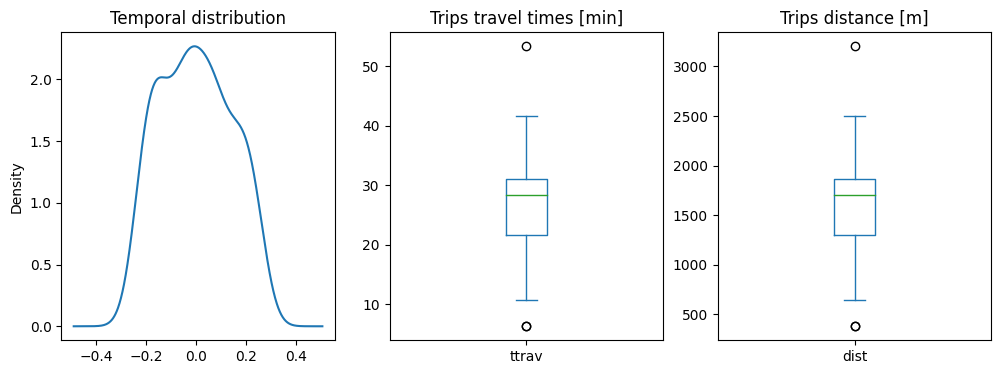

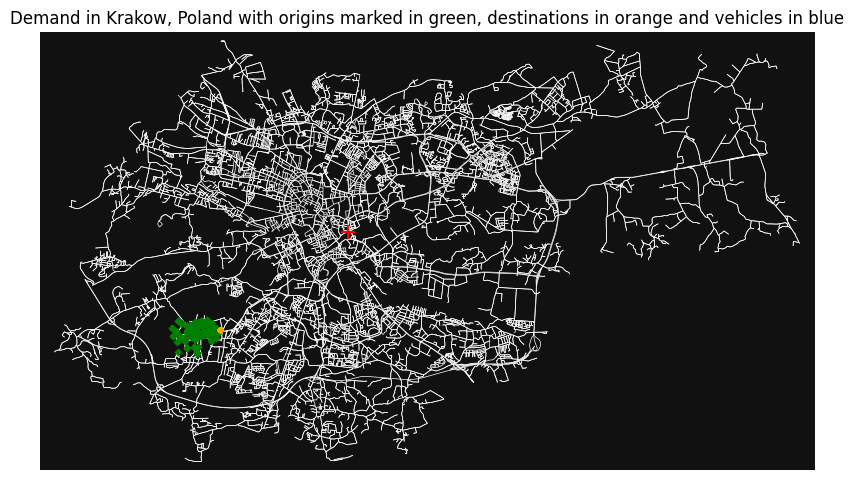

In [11]:
ExMAS.utils.plot_demand(inData, params)

In [12]:
inData.requests.head(1)

,origin_x,origin_y,destination_x,destination_y,treq,origin,destination,dist,ttrav,pax_id
155,19.878788,50.012225,19.95482,50.061079,2024-03-28 08:03:33,295825429,1989392511,1705,0 days 00:28:25,0


In [13]:
inData.sblts.requests.head(1)

,index,origin_x,origin_y,destination_x,destination_y,treq,origin,destination,dist,ttrav,pax_id,VoT,delta,u,u_PT,ride_id,ttrav_sh,u_sh,kind,position
0,0,19.879109,50.017161,19.896833,50.02339,0,2019014146,1989392511,1008,168,136,0.0035,27.692308,2.1,999999,0,168.0,2.1,1,0


In [14]:
inData.sblts.schedule.head(1)

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,lambda_r,PassHourTrav_ns,row,selected
0,[0],2.1,168,1,[2.1],"[0.0, 168.0]",[0],[0],1,0,0.2,168.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1


In [15]:
# inData.sblts.schedule[inData.sblts.schedule.degree != 1].to_csv(f'res/ExMASpooled_area10.csv')

In [16]:
df_SUM = df.copy()
df_SUM['index'] = inData.sblts.requests.index
df_SUM['hub'] = inData.sblts.requests.destination
df_SUM['ttrav'] = inData.sblts.requests.ttrav
df_SUM['tarr'] = pd.to_datetime(inData.requests.treq) + df_SUM.apply(lambda df_SUM: pd.Timedelta(df_SUM.ttrav, 's').floor('s'), axis=1)
df_SUM['u'] = inData.sblts.requests.u
df_SUM['ttrav_sh'] = inData.sblts.requests.ttrav_sh
df_SUM['tarr_sh'] = pd.to_datetime(inData.requests.treq) + df_SUM.apply(lambda df_SUM: pd.Timedelta(df_SUM.ttrav_sh, 's').floor('s'), axis=1)
df_SUM['u_sh'] = inData.sblts.requests.u_sh
# df_SUM.to_csv(f'res/ExMASrequests_OH_area10.csv')

## 2.2 OTP (HD) for ALL PT users

### 2.2.1 define ASC (utility for SUM)

In [17]:
# OPT (HD) for ALL PT users for ASC defenition

In [20]:
params.transfertime = 30 # transfertime for hub NSM-PT

df2 = df_SUM.rename(columns = {'treq': 'treq_origin'})
df2['origin_x'] = 19.88948 # hub coord_x
df2['origin_y'] = 50.01844 # hub coord_y
df2['treq'] = pd.to_datetime(df_SUM.tarr) + timedelta(seconds=params.transfertime) # treq for PT
df2.head(1)

,origin_x,origin_y,destination_x,destination_y,treq_origin,index,hub,ttrav,tarr,u,ttrav_sh,tarr_sh,u_sh,treq
0,19.88948,50.01844,19.896833,50.02339,2024-03-28 07:45:04,0,1989392511,168,2024-03-28 07:47:52,2.1,168.0,2024-03-28 07:47:52,2.1,2024-03-28 07:48:22


In [21]:
df_PT_HD = df2.apply(lambda row: 
                 parse_OTP_response(requests.get(OTP_API, params=make_query(row.squeeze())).json()), axis=1)

In [22]:
for name in list(df_PT_HD[0].keys()):
    vals = []
    for i in range(len(df_PT_HD)):
        if df_PT_HD[i]['success'] == True:
            vals.append(df_PT_HD[i][name])
        else:
            vals.append(None)
    df2[name] = vals
# df2[:3]

In [23]:
reqs_PT_HD_ASC = PT_utility(df2, params)
reqs_PT_HD_ASC.head(1)

,origin_x,origin_y,destination_x,destination_y,treq_origin,index,hub,ttrav,tarr,u,...,success,n_itineraries,duration,walkDistance,transfers,transitTime,waitingTime,modes,PT_fare,u_PT
0,19.88948,50.01844,19.896833,50.02339,2024-03-28 07:45:04,0,1989392511,168,2024-03-28 07:47:52,2.1,...,True,3,478,439.951789,0,120,2,"[[TRAM, 120, 1182], [WALK, 356, 439]]",1.126,4.126385


In [24]:
def calc_E_Psum(ASC=0):    
    df_SUM['u_SUM_OD'] = df_SUM.u + reqs_PT_HD_ASC.u_PT + ASC
    df_SUM['p_SUM'] = df_SUM.apply(lambda df_SUM: math.exp(df_SUM.u_SUM_OD), axis=1) / \
                     (df_SUM.apply(lambda df_SUM: math.exp(df_SUM.u_SUM_OD), axis=1) +  \
                      reqs_PT_OD.apply(lambda reqs_PT_OD: math.exp(reqs_PT_OD.u_PT), axis=1))
    return df_SUM.p_SUM.mean()

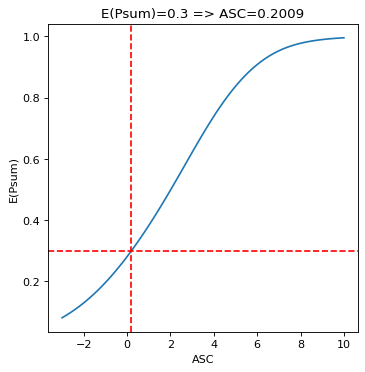

In [25]:
# Calculate ASC for the given E(Psum)
EPsum = 0.3
asc_opt = optimize.fsolve(lambda x: calc_E_Psum(x) - EPsum, 0)[0]
# Show graphics
ascs = np.linspace(-3, 10, 100)
plt.figure(figsize=(5, 5), dpi=80)
plt.plot(ascs,  [calc_E_Psum(asc) for asc in ascs])
plt.title(f'E(Psum)={EPsum} => ASC={round(asc_opt, 5)}')
plt.xlabel('ASC')
plt.ylabel('E(Psum)')
plt.axhline(EPsum, color='red', linestyle='--')
plt.axvline(asc_opt, color='red', linestyle='--')
plt.show()

In [26]:
asc_opt

0.2009044319099312

In [28]:
# Average ASC
data = {'ASC': [0.2009044319099312]}
df_ASC = pd.DataFrame(data)
ASC = df_ASC.ASC.mean()
ASC

0.2009044319099312

### 2.2.2 Run updated OPT

In [29]:
df3 = df2.copy()
df3['treq'] = pd.to_datetime(df_SUM.tarr_sh) + timedelta(seconds=params.transfertime) # treq for PT

In [30]:
df_PT_HD = df3.apply(lambda row: 
                 parse_OTP_response(requests.get(OTP_API, params=make_query(row.squeeze())).json()), axis=1)

In [31]:
for name in list(df_PT_HD[0].keys()):
    vals = []
    for i in range(len(df_PT_HD)):
        if df_PT_HD[i]['success'] == True:
            vals.append(df_PT_HD[i][name])
        else:
            vals.append(None)
    df3[name] = vals
# df3[:3]

In [32]:
reqs_PT_HD = PT_utility(df3, params)
reqs_PT_HD.head(1)

,origin_x,origin_y,destination_x,destination_y,treq_origin,index,hub,ttrav,tarr,u,...,success,n_itineraries,duration,walkDistance,transfers,transitTime,waitingTime,modes,PT_fare,u_PT
0,19.88948,50.01844,19.896833,50.02339,2024-03-28 07:45:04,0,1989392511,168,2024-03-28 07:47:52,2.1,...,True,3,478,439.951789,0,120,2,"[[TRAM, 120, 1182], [WALK, 356, 439]]",1.126,4.126385


## 2.3 MODE CHOICE

In [33]:
# recalculate p_SUM
df_SUM['u_SUM_OD'] = df_SUM.u_sh + reqs_PT_HD.u_PT + ASC
df_SUM['p_SUM'] = df_SUM.apply(lambda df_SUM: math.exp(df_SUM.u_SUM_OD), axis=1) / \
                     (df_SUM.apply(lambda df_SUM: math.exp(df_SUM.u_SUM_OD), axis=1) +  \
                      reqs_PT_OD.apply(lambda reqs_PT_OD: math.exp(reqs_PT_OD.u_PT), axis=1))
df_SUM.sample(3)

,origin_x,origin_y,destination_x,destination_y,treq,index,hub,ttrav,tarr,u,ttrav_sh,tarr_sh,u_sh,u_SUM_OD,p_SUM
120,19.869432,50.020363,19.890834,50.053155,2024-03-28 08:13:04,120,1989392511,311,2024-03-28 08:18:15,3.8905,340.0,2024-03-28 08:18:44,3.829550,17.998065,0.262267
77,19.877516,50.017472,19.891447,50.069260,2024-03-28 07:56:12,77,1989392511,150,2024-03-28 07:58:42,1.8765,150.0,2024-03-28 07:58:42,1.876500,17.099954,0.009757
42,19.863425,50.020646,19.906643,50.030131,2024-03-28 08:13:27,42,1989392511,187,2024-03-28 08:16:34,2.3375,187.0,2024-03-28 08:16:34,2.285975,7.110772,0.031074


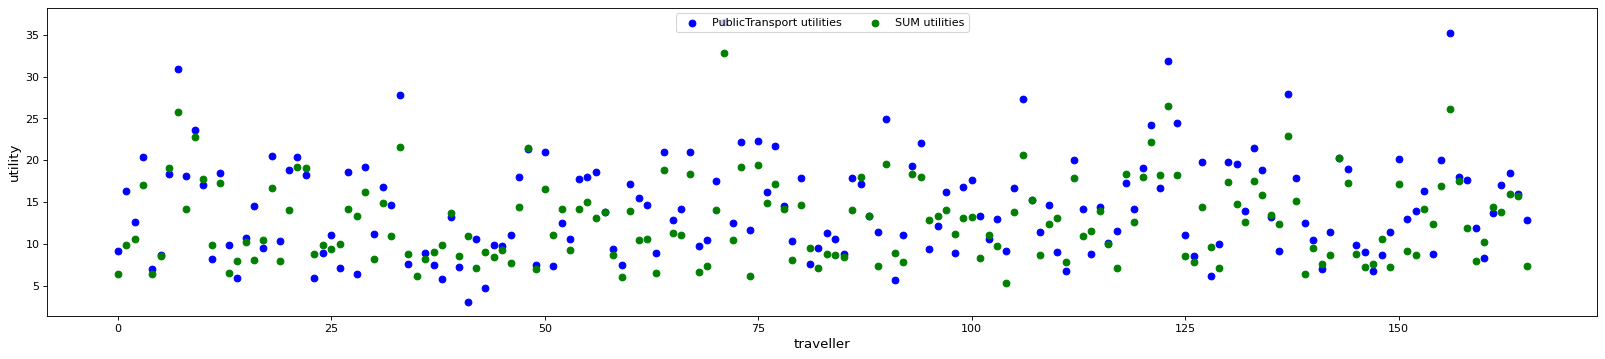

In [34]:
plt.figure(figsize=(25, 5), dpi=80)
u_PT_OD = plt.scatter(x = reqs_PT_OD.index, y = reqs_PT_OD.u_PT, color='blue')
u_SUM_OD = plt.scatter(x = df_SUM.index, y = df_SUM.u_SUM_OD, color='green')
# u_PrT = plt.scatter(x = df_SUM.index, y = df_PrT_OD.u_PrT, color='red')

plt.legend((u_PT_OD, u_SUM_OD), # , u_PrT
           ('PublicTransport utilities', 'SUM utilities'), # 'PrivatTransport utilities'
           scatterpoints=1,
           loc='upper center',
           ncol=3,
           fontsize=10)
plt.xlabel('traveller', fontsize=12)
plt.ylabel('utility', fontsize=12)
plt.show()

## 2.4 DEMAND FOR SUM

In [35]:
ts = []
for i in range(len(df_SUM)):
    if df_SUM.p_SUM[i] > 0.5:
        ts.append(1)
    else:
        ts.append(0)

In [37]:
df_SUM['t'] = ts 
df_SUM.sample(3)

,origin_x,origin_y,destination_x,destination_y,treq,index,hub,ttrav,tarr,u,ttrav_sh,tarr_sh,u_sh,u_SUM_OD,p_SUM,t
115,19.879998,50.019731,19.927148,50.001453,2024-03-28 07:47:28,115,1989392511,294,2024-03-28 07:52:22,3.6780,309.0,2024-03-28 07:52:37,3.591125,13.916957,0.383773,0
132,19.881072,50.021555,19.940893,50.030989,2024-03-28 07:59:06,132,1989392511,383,2024-03-28 08:05:29,4.7920,405.0,2024-03-28 08:05:51,4.754100,12.584471,0.205886,0
90,19.877275,50.021921,19.893211,50.077468,2024-03-28 07:56:57,90,1989392511,284,2024-03-28 08:01:41,3.5515,314.0,2024-03-28 08:02:11,3.538400,19.540498,0.004415,0


In [38]:
demand_SUM = df_SUM[df_SUM.p_SUM > 0.5]
demand_PT = df_SUM[df_SUM.p_SUM < 0.5]
frac_SUM = len(demand_SUM) /len(df_SUM)
frac_SUM

0.25903614457831325

In [50]:
# df_SUM[df_SUM.t != 1].to_csv(f'res/SUM chose_area10.csv')

In [39]:
len(demand_SUM)

43

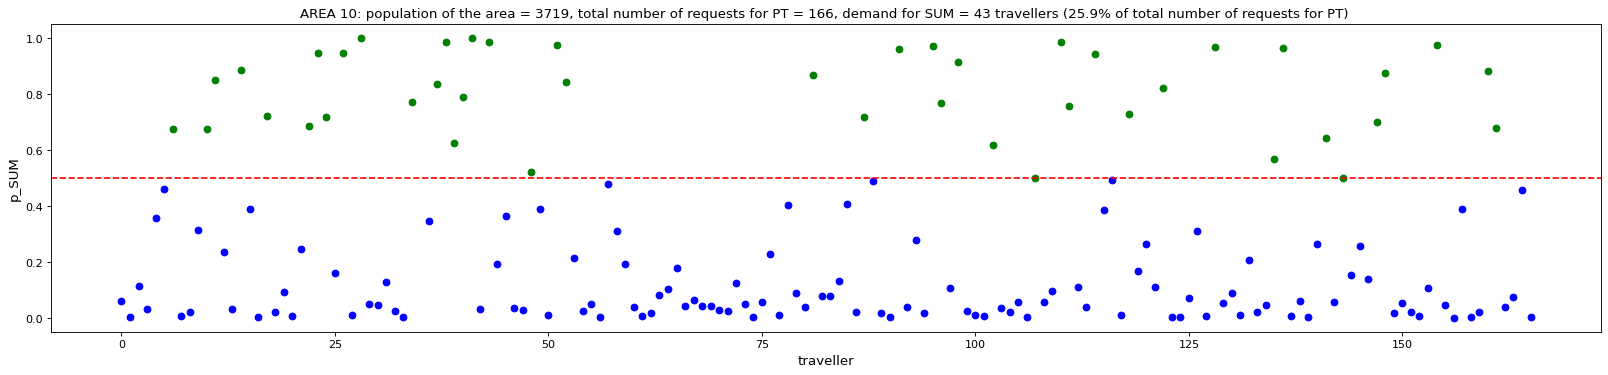

In [40]:
plt.figure(figsize=(25, 5), dpi=80)
plt.scatter(x = demand_SUM.index, y = demand_SUM.p_SUM, color='green')
plt.scatter(x = demand_PT.index, y = demand_PT.p_SUM, color='blue')
plt.axhline(0.5, color='red', linestyle='--')
plt.xlabel('traveller', fontsize=12)
plt.ylabel('p_SUM', fontsize=12)
plt.title(f'AREA 10: population of the area = 3719, total number of requests for PT = {len(df_SUM) }, demand for SUM = {len(demand_SUM)} travellers ({round(frac_SUM * 100, 1)}% of total number of requests for PT) ')
plt.show()

# plt.savefig('p10.jpg')
# plt.savefig('p(10).jpg', bbox_inches='tight', dpi=100)

## ExMAS (OH) for SUM users

In [54]:
def run_ExMAS_SUM(inData, params, hub, frac, repl):

    params.nP = int(frac * len(demand_SUM))
    sample = demand_SUM.sample(n = int(frac * len(demand_SUM)), replace=False, weights=None, random_state=None, axis=None) # demand of RP=frac*population
    sample['origin'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['origin_y'], row['origin_x'])), axis = 1)
    # sample['destination'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['desti_y'], row['desti_x'])), axis = 1) # in case of O-D by PT
    if type(sample['treq'][0]) == str:
        sample['treq'] = sample['treq'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    # inData = ExMAS.utils.generate_demand(inData, params) #generate trip requests 
    inData.requests = sample
    
    
    my_requests = inData.requests
    my_requests['destination'] = hub[1] 
    my_requests["origin"] = sample.origin.values
    my_requests['dist'] = my_requests.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
    my_requests['ttrav'] = my_requests.apply(lambda request: pd.Timedelta(request.dist, 's').floor('s'), axis=1) 
    my_requests.tarr = [request.treq + request.ttrav for _, request in my_requests.iterrows()]
    my_requests['pax_id'] = list(range(len(my_requests)))
    
       
    inData.requests = my_requests
    # inData.requests.to_csv(f'res/10/ttrav_{hub[0]}_{frac}_{repl}.csv')
    inData = ExMAS.main(inData, params)
    schedule = inData.ExMAS.schedule
    requests = inData.ExMAS.requests
   
    KPIs = inData.sblts.res.to_frame()[:23]
    # KPIs['description']  = ExMAS.utils.KPIs_descriptions
    KPIs.columns = ['KPI']
    KPIs
    KPIs.to_csv(f'res/10/KPI_{hub[0]}_{frac}_{repl}.csv') #res/     
   
    return KPIs, schedule, requests

params.shared_discount = 0.2
params.simTime = 0.5
params.t0 = params.t0.replace(hour=8)
params.speeds.ride = 6
params.VoT = 0.0035
params.pax_delay = 15
params.max_degree = 2 
params.price = 1.5
results = dict()
 
#    hubs   
hubs = [('hub1', ox.get_nearest_node(inData.G,[50.01844,19.88948]))]#

for frac in  [1]: #list of frac 0.001, 0.0015, 0.002, 0.003, 0.005, 0.007, 0.008, 0.009, 0.01
    for h in hubs:
        for i in range(1): 
            print(h[0], frac, i + 1)
            results[frac] = run_ExMAS_SUM(inData, params, h, frac, i)

hub1 1 1


KeyError: 0

## len(df)

In [202]:
results = {}
for num, frac, rep in list(itertools.product([1], [frac_SUM, frac_SUM-0.1, frac_SUM+0.1], range(11))):
    results[str((num, frac, rep))] = pd.read_csv('res/10/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv")["KPI"]
indexes = pd.read_csv('res/10/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv", index_col=0).index
dfr = pd.DataFrame(results)
dfr.index = indexes
old_indexes = list(dfr.index).copy()
dfr = dfr.append({t: t[1] for t in dfr.columns}, ignore_index=True)
dfr.index = old_indexes + ["hub"]
# print(dfr)
dfr.to_csv('res/10/result10_(11).csv')
# dfr.head()

,"(1, 0.3132530120481928, 0)","(1, 0.3132530120481928, 1)","(1, 0.3132530120481928, 2)","(1, 0.3132530120481928, 3)","(1, 0.3132530120481928, 4)","(1, 0.3132530120481928, 5)","(1, 0.3132530120481928, 6)","(1, 0.3132530120481928, 7)","(1, 0.3132530120481928, 8)","(1, 0.3132530120481928, 9)",...,"(1, 0.41325301204819276, 1)","(1, 0.41325301204819276, 2)","(1, 0.41325301204819276, 3)","(1, 0.41325301204819276, 4)","(1, 0.41325301204819276, 5)","(1, 0.41325301204819276, 6)","(1, 0.41325301204819276, 7)","(1, 0.41325301204819276, 8)","(1, 0.41325301204819276, 9)","(1, 0.41325301204819276, 10)"
VehHourTrav,10695,11115,11166,11079,9708,11038,10493,11516,12324,10967,...,13816,14091,13508,15221,14952,13780,13683,13336,14201,14645
VehHourTrav_ns,13203,14095,13556,14025,13360,13953,13772,13796,13975,13147,...,18806,17565,18352,18722,18255,17725,17463,18034,17609,17630
PassHourTrav,13466,14298,13825,14233,13664,14189,14060,13975,14122,13301,...,19175,17856,18819,19015,18541,18002,17806,18367,17874,17926
PassHourTrav_ns,13203,14095,13556,14025,13360,13953,13772,13796,13975,13147,...,18806,17565,18352,18722,18255,17725,17463,18034,17609,17630
PassUtility,163.36169999999998,174.24970000000002,167.59645,173.84815000000003,164.30545,172.83375000000004,170.5021,171.04010000000005,173.8744,162.69165,...,232.31937500000004,217.02135,226.19700000000003,231.58335000000002,225.17465000000004,218.88880000000003,215.65935,222.27455,218.132825,218.54700000000003


In [203]:
pd.read_csv('res/10/result10_(11).csv', header=None).T.to_csv('res/10/resultT10_(11).csv', header=False, index=False)

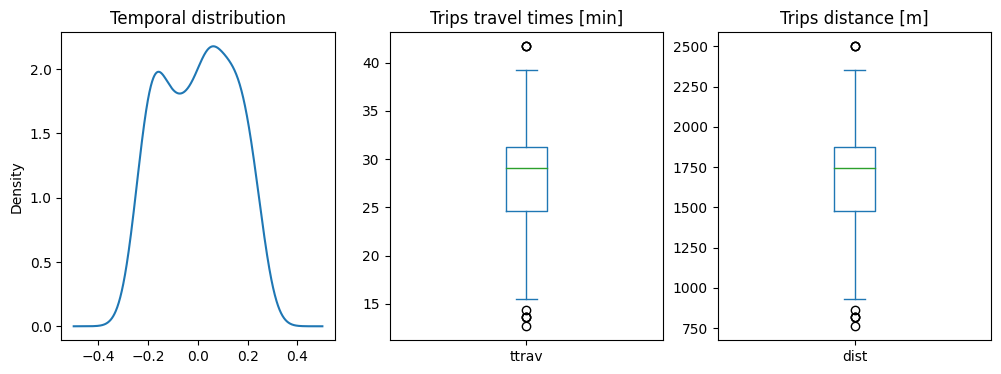

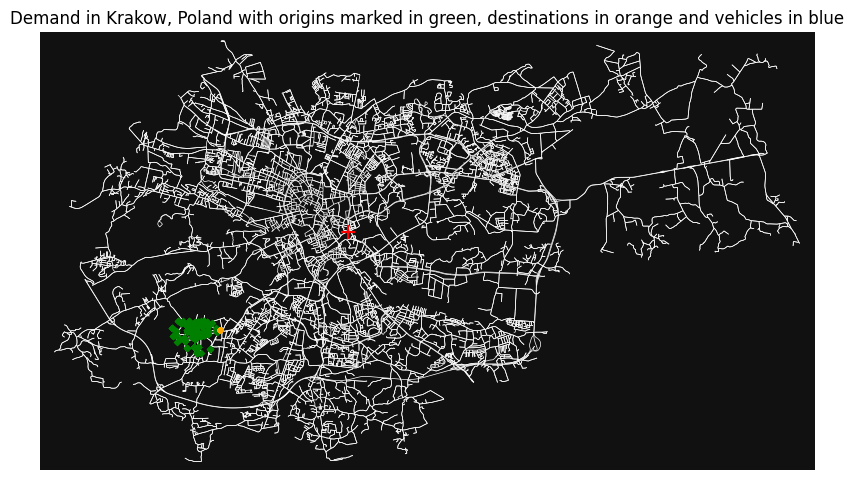

In [20]:
ExMAS.utils.plot_demand(inData, params)